<a href="https://colab.research.google.com/github/Deveshq/Msc-Project/blob/main/CZ_Entanglement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entanglement & Bell State Prepration
    (Neutral Atom Quantum Computing Simulation)

> _Devesh Kumar          
> MSc Physics        
> IIT Roorkee_

In this notebook, we are going to simulate preparation of Bell-states using CZ-CNOT pulse sequence.

In [1]:
#Some general imports
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
from itertools import product

#Some imports from pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

import qutip
from qutip import bell_state, Qobj, fidelity, basis, tensor

## Defining Register
The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $6 \mu m$, named `Control` and `Target` for 'control' and 'target' respectively.

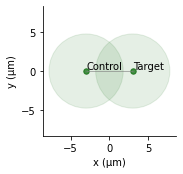

In [2]:
qubits = {'Control': (-3,0) , 'Target': (3,0) }

Omega_max = 2.3 * pi
blockade_radius = Chadoq2.rydberg_blockade_radius(Omega_max)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)


## State preparation
This part of sequence corresponds to preparing the different states on which the CNOT gate will act. First we define a function which generate the ket corressponing to given state.

In [3]:
def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

Let's check, how the state preparation function working,

In [4]:
state = state_prep('ge', 'digital')
print(state)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]


It generates corrects state. Now we need to define pulse sequence for preparing the state. For this, we define the following Pulse instances:

In [5]:
pi_wf = BlackmanWaveform(200, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

In [6]:
def prep_seq(sid, reg):
    global seq
    
    seq = Sequence(reg, Chadoq2)

    #Declare channel
    seq.declare_channel('raman', 'raman_local')
    seq.declare_channel('ryd', 'rydberg_local', 'Control')
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq_dict = {'1':'Target', '0':'Control'}
    
    basis = 'digital'
    if sid == 'gg':
        seq.target('Control', 'raman')
    else:
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
        
    prep_state = state_prep(sid, basis)
            
    return prep_state

## Entanglement Sequence
Our state preparation part has been completed. Now we define pulse sequence for the bell-pair.

In [7]:
half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)

pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)



Let's define a function which takes state id as input, prepare the state and applies Hadamard & CZ-CNOT sequences.

In [8]:
def ENT(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #Hadamard sequence
    seq.target('Control', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')
    seq.align('raman', 'ryd')
    
    #CNOT sequence:
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')# Wait for state preparation.
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd')
    seq.target('Target', 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target('Control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')
    
    seq.align('raman', 'ryd')
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse_d, 'raman')
    
    seq.measure(basis = 'digital')
    return prep_state, prep_time

## Simulating the Sequence
Let's define a function which combines all the functions defined above. This function takes state id as input, use `prep_state` function for state prepartion and `ENT` function for applying the entanglement sequence, and returns the sequence, its plot, prepared state, preapration time, counts after simulation, and plots a bar graph for these counts.

In [9]:
def Sim_Ent(sid):
    # State prep
    prep_state, prep_time = ENT(sid) # constructs seq, prep_state and prep_time
    print(f'\nPrepared state --> {prep_state}')
    print(f'\nPreparation time: {prep_time}ns \n\n')
    print(f'Sequence\n\n{seq}')
    print('\n\n Plot of sequence\n')
    seq.draw(draw_phase_area=True)

    # Construct Simulation instance
    sim = Simulation(seq)
    cfg = SimConfig(noise=('SPAM', 'doppler'), eta = 0.08, temperature = 200, runs = 1000) 
    sim.set_config(cfg)

    res = sim.run()
    
    Out_state.append(res.get_final_state())
    count = res.sample_final_state(N_samples=1e3)
    print('Output\n')
    print(f'\nFor the Bell state B1: Input- ({sid})\n\nCounts: {count}\n')
    
    most_freq = {k:v for k,v in count.items() if v>5}
    
    plt.figure(figsize=(10,5))
    plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
    plt.xticks()
    plt.show()



### For input state '00'

Bell state: $|B_1⟩ = \frac{|00⟩ + |11⟩}{\sqrt{2}}$


Prepared state --> Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

Preparation time: 0ns 


Sequence

Channel: raman
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Control
t: 100->220 | Target: Target | Phase Reference: 0.0
t: 220->320 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 320->1020 | Delay 
t: 1020->1120 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: Target

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->320 | Delay 
t: 320->520 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 520->520 | Target: Target | Phase Reference: 0.0
t: 520->820 | Pulse(Amp=Blackman(Area: 6.28), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 820->820 | Target: Control | Phase Reference: 0.0
t: 820->

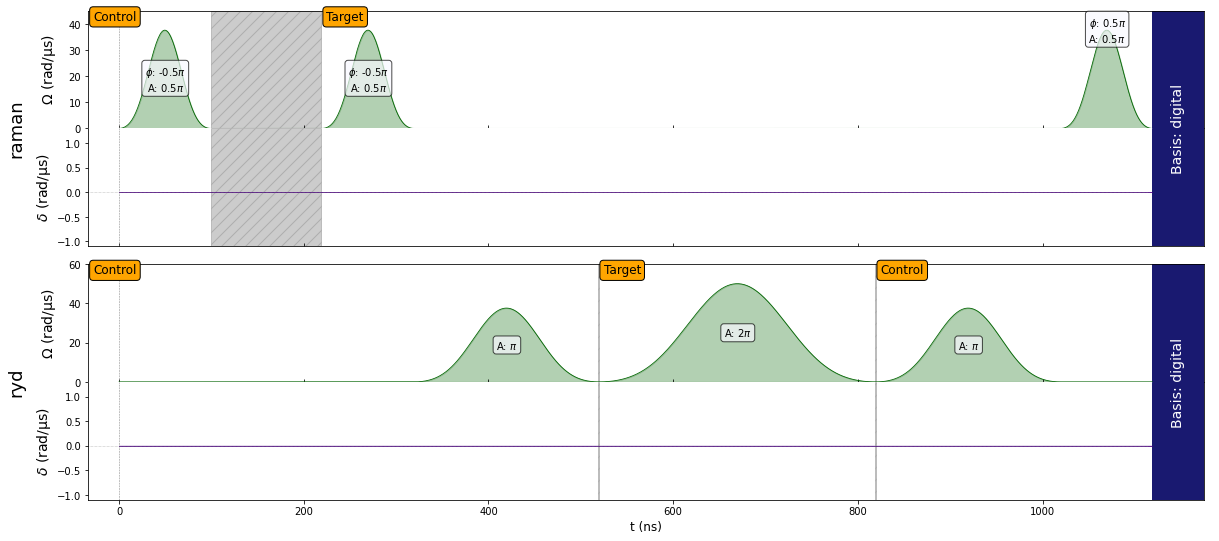

Output


For the Bell state B1: Input- (gg)

Counts: Counter({'00': 463, '11': 374, '01': 100, '10': 63})



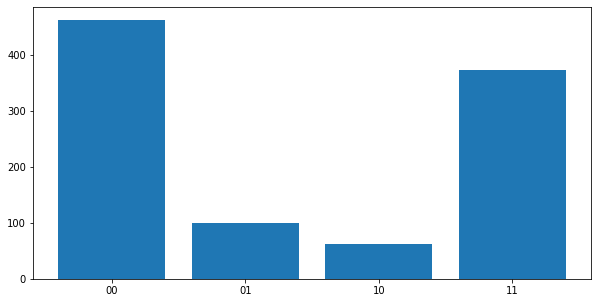

In [11]:
Out_state = [ ]

Sim_Ent('gg')

### For input state '01'

Bell state: $|B_2⟩ = \frac{|01⟩ + |10⟩}{\sqrt{2}}$


Prepared state --> Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

Preparation time: 200ns 


Sequence

Channel: raman
t: 0 | Initial targets: Target | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 200->220 | Target: Control | Phase Reference: 0.0
t: 220->320 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Control
t: 320->440 | Target: Target | Phase Reference: 0.0
t: 440->540 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 540->1240 | Delay 
t: 1240->1340 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: Target

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->320 | Delay 
t: 320->540 | Delay 
t: 540->740 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 740->740 | Target: Target | Phase Reference: 0.0
t: 7

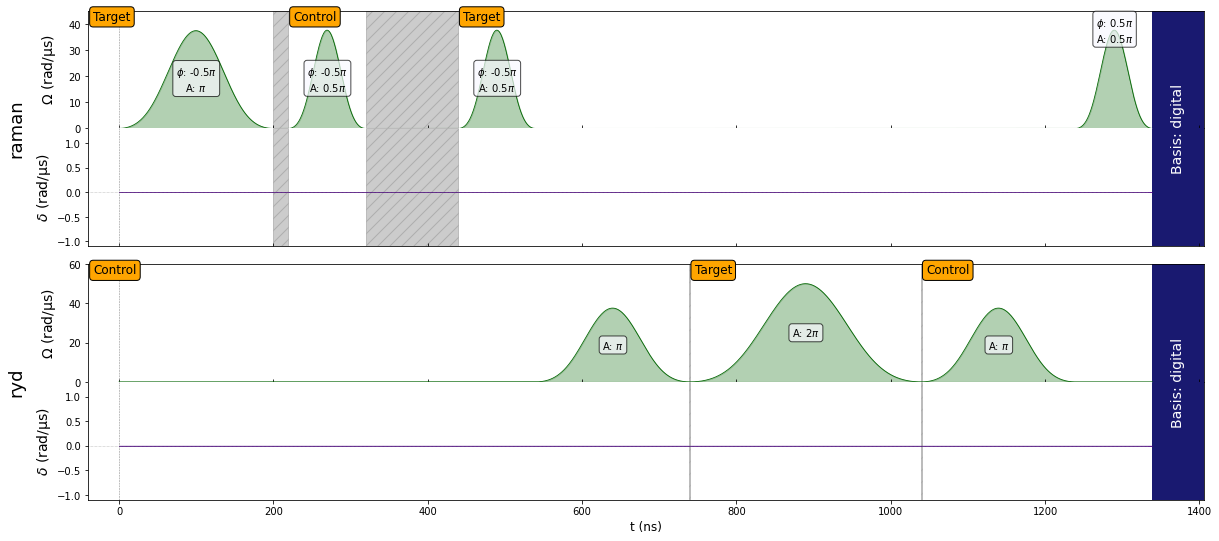

Output


For the Bell state B1: Input- (ge)

Counts: Counter({'10': 433, '01': 380, '00': 177, '11': 10})



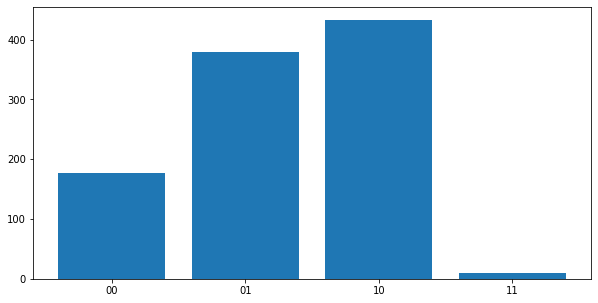

In [12]:
Sim_Ent('ge')

## Output states
Let's what are the output states in both cases.

In [13]:
Out_state

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.4272 0.     0.     0.    ]
  [0.     0.1246 0.     0.    ]
  [0.     0.     0.0642 0.    ]
  [0.     0.     0.     0.384 ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.1756 0.     0.     0.    ]
  [0.     0.3826 0.     0.    ]
  [0.     0.     0.4328 0.    ]
  [0.     0.     0.     0.009 ]]]

In [15]:
s = []
d = []

for i in range(len(Out_state)):
  x = np.sqrt(Out_state[i].diag())
  st = Qobj(x, dims = [[2, 2], [1, 1]], shape = (4, 1), type = 'ket')
  dn = st * st.dag()
  s.append(st)
  d.append(dn)
  print(f'Output state for Bell state B{i+1}:\n\n{st}')
  print(f'\n\nDensity matrix corressponding to this state:\n\n{dn}\n\n\n')



Output state for Bell state B1:

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.65360539]
 [0.35298725]
 [0.25337719]
 [0.61967734]]


Density matrix corressponding to this state:

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.4272     0.23071437 0.1656087  0.40502444]
 [0.23071437 0.1246     0.08943892 0.2187382 ]
 [0.1656087  0.08943892 0.0642     0.1570121 ]
 [0.40502444 0.2187382  0.1570121  0.384     ]]



Output state for Bell state B2:

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.41904654]
 [0.61854668]
 [0.65787537]
 [0.09486833]]


Density matrix corressponding to this state:

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.1756     0.25919985 0.27568039 0.03975425]
 [0.25919985 0.3826     0.40692663 0.05868049]
 [0.27568039 0.40692663 0.4328     0.06241154]
 [0.03975425 0.05868049 0.06241154 0.00

## Entanglement verification and Fidelity


#### For the Bell state $B_1$

Input: `'00'`

$$
|B_1⟩ =  \frac{|00⟩ + |11⟩}{\sqrt{2}}
$$


The fidelity for state $B_1$ is given by:

$$
F = \frac{1}{2}(P_{00} + P_{11}) + c_1
$$

Where $c_1$ is the coherence between the |00⟩ and |11⟩ states. For the $F\leq 1/2$, the state can be written as a product state. So the value of $F$ larger than $1/2$ is an entangled state.


Density metrix:
$$ 𝝆_{00} = 
\begin{bmatrix}
  0.4272 & 0.2307 & 0.1656 & 0.4050 \\
  0.2307 & 0.1246 & 0.0894 & 0.2187 \\
  0.1656 & 0.0894 & 0.0642 & 0.1570 \\
  0.4050 & 0.2187 & 0.1570 & 0.3840  
\end{bmatrix}
$$

From density metrix, we get $ P_{00} = 0.4272 $, $ P_{11} = 0.3840 $, and $ c_1 = 0.4050$.

Hence, 

$$
F = \frac{1}{2}(0.4272 + 0.3840) + 0.4050 \\
\implies F = 0.8106
$$

#### For the Bell state $B_2$

Input: `'01'`

$$
|B_2⟩ =  \frac{|01⟩ + |10⟩}{\sqrt{2}}
$$


Similarly, the fidelity for the $B_2$ is given by:

$$
F = \frac{1}{2}(P_{01} + P_{10}) + c_2
$$

Where $c_2$ is the coherence between the |01⟩ and |10⟩ states.


Density metrix: 
$$ 𝝆_{01} =
\begin{bmatrix}
  0.1756 & 0.2591 & 0.2756 & 0.0397 \\
  0.2591 & 0.3826 & 0.4069 & 0.0586 \\
  0.2756 & 0.4069 & 0.4328 & 0.0624 \\
  0.0397 & 0.0586 & 0.0624 & 0.0090  
\end{bmatrix}
$$

From density metrix, we get $ P_{01} = 0.3826 $, $ P_{10} = 0.4328 $, and $ c_2 = 0.4069$.

Hence, 

$$
F = \frac{1}{2}(0.3826 + 0.4328) + 0.4069 \\
\implies F = 0.8146
$$

#### Result
We see that the value of $F$ is greater than $1/2$ in both the cases. So we can say that both the outputs are entangled states.

###### Ref: Demonstration of Rydberg Blockade, A Neutral Atom CNOT Gate, and Entanglement Generation by Larry Isenhower